In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
train_data = pd.read_csv('data/MNIST/train.csv')
x_test = pd.read_csv('data/MNIST/test.csv')

In [3]:
# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Training data shape: (33600, 785)
Validation data shape: (8400, 785)


# EDA:
---

In [82]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34941,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24433,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24432,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30291,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
train_data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,33600.000000,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,...,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.0,33600.0,33600.0,33600.0
mean,4.455893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.232589,0.123899,0.066042,0.025238,0.021548,0.003571,0.0,0.0,0.0,0.0
std,2.888117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.689593,4.625719,3.520927,1.967568,2.118097,0.463160,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


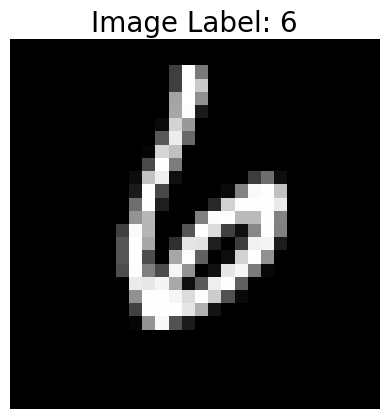

In [ ]:
# Displaying the first image
first_image = train_data.iloc[0,1:].values.reshape(28, 28) 
plt.imshow(first_image, cmap='gray') 
plt.title(
    f'Image Label: {train_data.iloc[0,0]}', fontsize=20
)  
plt.axis('off') 
plt.show()

In the histogram below we can see a rougly even distribution of data across classes.

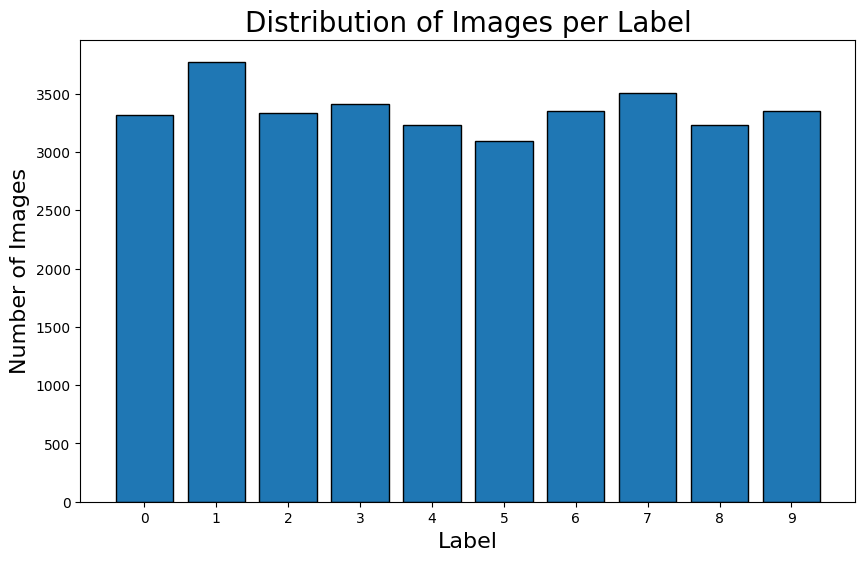

In [58]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
counts, bins, bars = plt.hist(
    train_data['label'], bins=10, edgecolor='black', rwidth=0.8
)
plt.title('Distribution of Images per Label', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Number of Images', fontsize=16)
plt.xticks(
    bins[:-1] + (bins[1] - bins[0]) / 2,
    labels=range(10),
)
plt.show()

In [15]:
print('There are', train_data.isna().sum().sum(), 'missing values in training data.')

There are 0 missing values in training data.


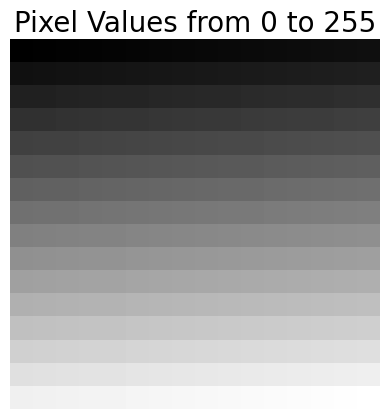

In [188]:
image_data = np.array(range(256))
image = image_data.reshape(16, 16)

plt.imshow(image, cmap='gray') 
plt.title('Pixel Values from 0 to 255', fontsize=20)
plt.axis('off')
plt.show()

Looking at the distribution of pixel values in the first figures below, we can see that highest frequency value 0 (black pixel). If we exclude 0 (as in the second figure below) we can see a concentration of pixels > 250 (light grey to white). Both of these make sense when we think about what MNIST images look like.

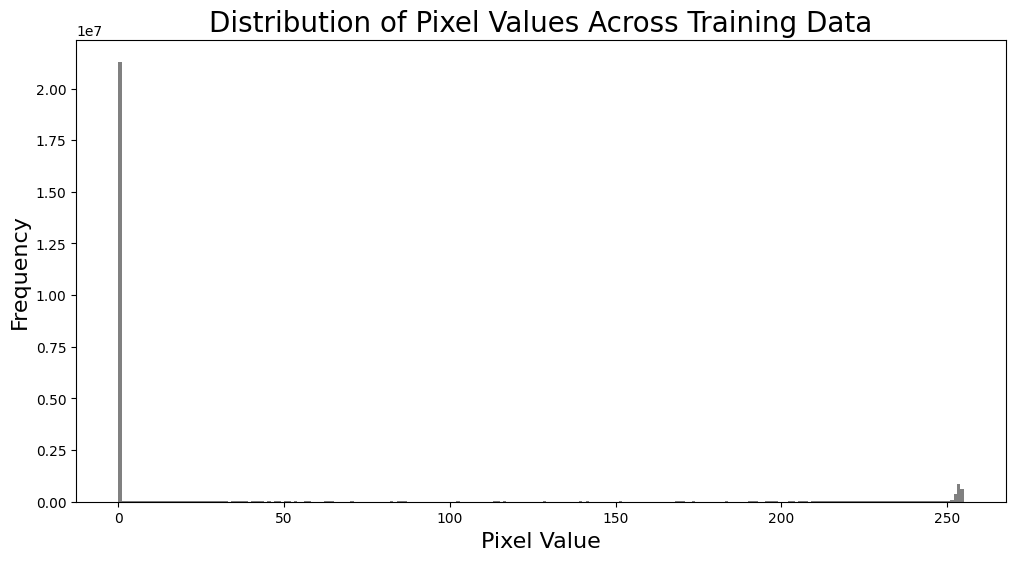

In [96]:
pixel_values = train_data.drop('label', axis=1).values.flatten()

# Plotting the distribution of pixel values
plt.figure(figsize=(12, 6))
plt.hist(pixel_values, bins=255, color='gray')
plt.title('Distribution of Pixel Values Across Training Data', fontsize=20)
plt.xlabel('Pixel Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

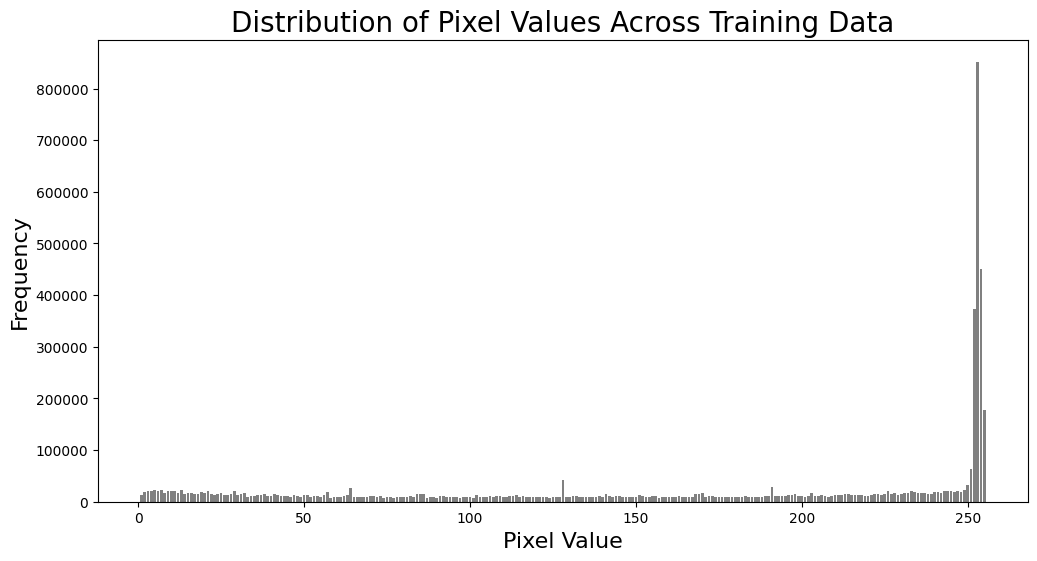

In [51]:
# Flatten pixel values for the entire dataset
pixel_values = train_data.drop('label', axis=1).values.flatten()
pixel_values = pd.Series(pixel_values).value_counts()
pixel_values = pixel_values.sort_index()
plt.figure(figsize=(12, 6))
plt.bar(pixel_values.index[1:], pixel_values[1:], color='gray')
plt.title('Distribution of Pixel Values Across Training Data', fontsize=20)
plt.xlabel('Pixel Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

# Preprocessing:
---

In [ ]:
# divide the data into features and labels
x_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
x_val = val_data.drop('label', axis=1).values
y_val = val_data['label'].values
x_test = x_test.values

In [ ]:
batch_size = 32

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
test_indices_tensor = torch.tensor(np.arange(len(x_test_tensor)), dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, test_indices_tensor)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model 1:
---

In [319]:
submission_filepath = 'programming_assignment_3_submissions/model_1_submission.csv'

In [287]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
print(f'Training Accuracy: {rf.score(x_train, y_train)*100:.2f}%')

print(f'Validation Accuracy: {rf.score(x_val, y_val)*100:.2f}%')

Training Accuracy: 100.00%
Validation Accuracy: 96.29%


In [320]:
test_preds = pd.DataFrame()
test_preds['ImageId'] = np.arange(1, len(x_test_tensor)+1)
test_preds['Label'] = rf.predict(x_test)
print(test_preds.head())
test_preds.to_csv(submission_filepath, index=False)

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


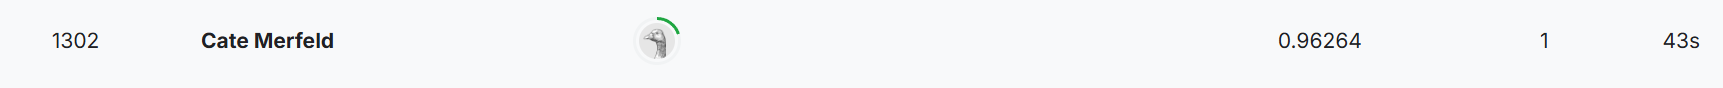

# Model 2:
---

For my second model I'll try a CNN on a PCA transformation of the data.

In [321]:
submission_filepath = 'programming_assignment_3_submissions/model_2_submission.csv'

In [295]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [ ]:
pca = PCA()
x_train_pca = pca.fit(x_train_scaled)

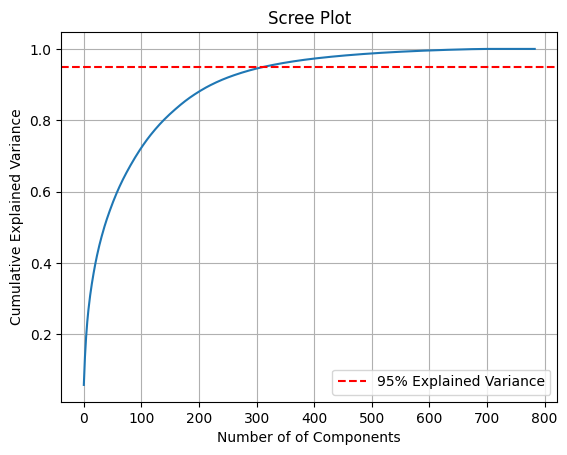

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of of Components')
plt.ylabel('Cumulative Explained Variance') 
plt.axhline(
    y=0.95, color='r', linestyle='--', label="95% Explained Variance"
)
plt.legend()
plt.title('Scree Plot')
plt.grid(True)
plt.show()

Based on the plot above, I will use ~300 components to maintain 95% of explained variance.

In [306]:
pca = PCA(n_components=324)
batch_size = 64
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

x_train_pca_tensor = torch.tensor(x_train_pca, dtype=torch.float32).reshape(-1, 1, int(np.sqrt(x_train_pca.shape[1])), int(np.sqrt(x_train_pca.shape[1])))
x_val_pca_tensor = torch.tensor(x_val_pca, dtype=torch.float32).reshape(-1, 1, int(np.sqrt(x_val_pca.shape[1])), int(np.sqrt(x_val_pca.shape[1])))
x_test_pca_tensor = torch.tensor(x_test_pca, dtype=torch.float32).reshape(-1, 1, int(np.sqrt(x_test_pca.shape[1])), int(np.sqrt(x_test_pca.shape[1])))

train_dataset_pca = TensorDataset(x_train_pca_tensor, y_train_tensor)
val_dataset_pca = TensorDataset(x_val_pca_tensor, y_val_tensor)
test_dataset_pca = TensorDataset(x_test_pca_tensor, test_indices_tensor)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
val_loader_pca = DataLoader(val_dataset_pca, batch_size=batch_size, shuffle=False)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs): 
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(
                    f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}'
                )
                running_loss = 0.0

        # Validation step
        model.eval()  
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(
            f'Epoch [{epoch+1}/{epochs}], Validation Accuracy: {100 * correct / total:.2f}%'
        )

    print('Finished Training')

In [297]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10) 
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [312]:
epochs = 10
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(
    model, train_loader_pca, val_loader_pca, 
    criterion, optimizer, epochs
)

Epoch [1/10], Step [100/525], Loss: 1.6045
Epoch [1/10], Step [200/525], Loss: 0.7538
Epoch [1/10], Step [300/525], Loss: 0.4979
Epoch [1/10], Step [400/525], Loss: 0.4043
Epoch [1/10], Step [500/525], Loss: 0.3781
Epoch [1/10], Validation Accuracy: 91.30%
Epoch [2/10], Step [100/525], Loss: 0.2983
Epoch [2/10], Step [200/525], Loss: 0.2623
Epoch [2/10], Step [300/525], Loss: 0.2435
Epoch [2/10], Step [400/525], Loss: 0.2356
Epoch [2/10], Step [500/525], Loss: 0.2786
Epoch [2/10], Validation Accuracy: 92.75%
Epoch [3/10], Step [100/525], Loss: 0.2053
Epoch [3/10], Step [200/525], Loss: 0.1887
Epoch [3/10], Step [300/525], Loss: 0.1831
Epoch [3/10], Step [400/525], Loss: 0.1996
Epoch [3/10], Step [500/525], Loss: 0.1922
Epoch [3/10], Validation Accuracy: 93.82%
Epoch [4/10], Step [100/525], Loss: 0.1604
Epoch [4/10], Step [200/525], Loss: 0.1685
Epoch [4/10], Step [300/525], Loss: 0.1669
Epoch [4/10], Step [400/525], Loss: 0.1568
Epoch [4/10], Step [500/525], Loss: 0.1591
Epoch [4/10], 

In [ ]:
# Create test predictions for submission
model.eval() 
predictions = []
indices = []
with torch.no_grad():
    for i, (data, index) in enumerate(test_loader_pca):
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission_df.to_csv(submission_filepath, index=False)
print(f'Submission file created: {submission_filepath}')

Submission file created: programming_assignment_3_submissions/model_2_submission.csv


This second model took longer to train than the first and model performance was slightly worse. Since this model didn't perform as well as the last, GitHub doesn't place the submission on the leaderboard so I included a screenshot showing the submission. Since it doesn't include my team name I took the screenshot so that it also includes my previous submission (to show it's mine).

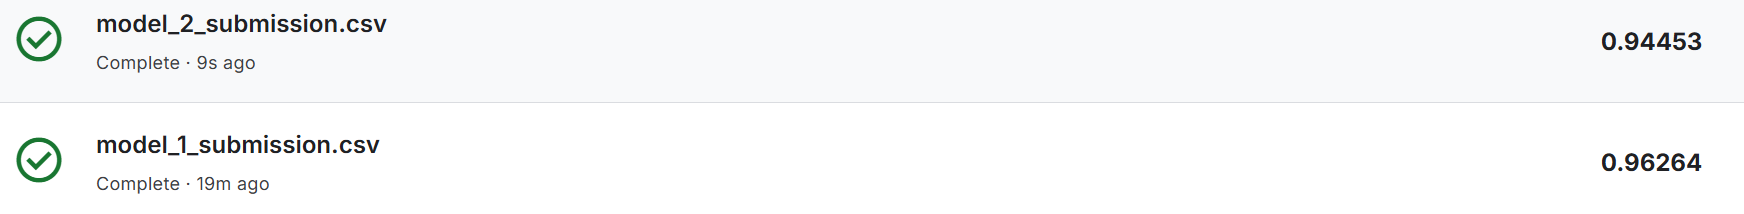

# Model 3:
---

I'll base my last model on the [PyTorch CNN tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). This model won't use PCA and will use SGD as an optimizer instead of Adam. The model will have slightly different architecture to account for the different shape of the data.

In [281]:
submission_filepath = 'programming_assignment_3_submissions/model_3_submission.csv'

In [216]:
epochs = 10

In [282]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(1,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [283]:
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, epochs
)

Epoch [1/10], Step [100/1050], Loss: 0.9111
Epoch [1/10], Step [200/1050], Loss: 0.2843
Epoch [1/10], Step [300/1050], Loss: 0.2082
Epoch [1/10], Step [400/1050], Loss: 0.1763
Epoch [1/10], Step [500/1050], Loss: 0.1688
Epoch [1/10], Step [600/1050], Loss: 0.1409
Epoch [1/10], Step [700/1050], Loss: 0.1219
Epoch [1/10], Step [800/1050], Loss: 0.1101
Epoch [1/10], Step [900/1050], Loss: 0.1025
Epoch [1/10], Step [1000/1050], Loss: 0.1031
Epoch [1/10], Validation Accuracy: 96.05%
Epoch [2/10], Step [100/1050], Loss: 0.0787
Epoch [2/10], Step [200/1050], Loss: 0.1050
Epoch [2/10], Step [300/1050], Loss: 0.0780
Epoch [2/10], Step [400/1050], Loss: 0.0936
Epoch [2/10], Step [500/1050], Loss: 0.0654
Epoch [2/10], Step [600/1050], Loss: 0.0726
Epoch [2/10], Step [700/1050], Loss: 0.0664
Epoch [2/10], Step [800/1050], Loss: 0.0883
Epoch [2/10], Step [900/1050], Loss: 0.0733
Epoch [2/10], Step [1000/1050], Loss: 0.0680
Epoch [2/10], Validation Accuracy: 97.50%
Epoch [3/10], Step [100/1050], Los

In [284]:
# Create test predictions for submission
model.eval() 
predictions = []
indices = []
with torch.no_grad():
    for i, (data, index) in enumerate(test_loader):
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission_df.to_csv(submission_filepath, index=False)
print(f'Submission file created: {submission_filepath}')

Submission file created: programming_assignment_3_submissions/model_3_submission.csv


This model performed the best of the three I created. 

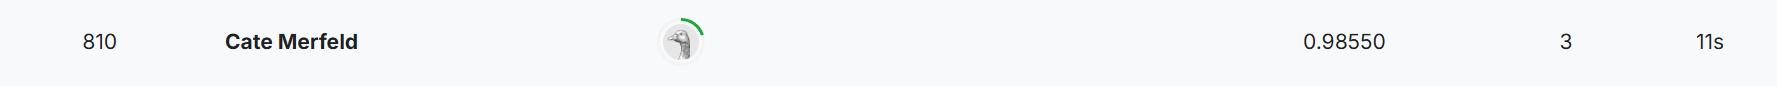